# Journal Profiling Part 1: Getting the Data

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to extract [publications data ](https://docs.dimensions.ai/dsl/datasource-publications.html) for a specific journal, as well its authors and affiliations.

This tutorial is the first of a series that uses the data extracted in order to generate a 'journal profile' report. See the [API Lab homepage](https://api-lab.dimensions.ai/) for the other tutorials in this series.


In this notebook we are going to:

* extract all publications data for a given journal
* have a quick look at the publications' authors and affiliations 
* review how many authors have been disambiguated with a Dimensions Researcher ID
* produce a dataset of non-disambiguated authors that can be used for manual disambiguation 

In [17]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Jan 24, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).


In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *
import os, sys, time, json
from tqdm.notebook import tqdm as progress
import pandas as pd
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


Some helper functions to store the data we are going to extract

In [2]:
# create output data folder
FOLDER_NAME = "journal-profile-data"
if not(os.path.exists(FOLDER_NAME)):
    os.mkdir(FOLDER_NAME)
    
def save(df,filename_dot_csv):
    df.to_csv(FOLDER_NAME+"/"+filename_dot_csv, index=False)

## Selecting a Journal and Extracting All Publications Metadata

In [3]:
#@title Select a journal from the dropdown
#@markdown If the journal isn't there, you can try type in the exact name instead.

journal_title = "Nature Genetics" #@param ['Nature', 'Nature Communications', 'Nature Biotechnology', 'Nature Medicine', 'Nature Genetics', 'Nature Neuroscience', 'Nature Structural & Molecular Biology', 'Nature Methods', 'Nature Cell Biology', 'Nature Immunology', 'Nature Reviews Drug Discovery', 'Nature Materials', 'Nature Physics', 'Nature Reviews Neuroscience', 'Nature Nanotechnology', 'Nature Reviews Genetics', 'Nature Reviews Urology', 'Nature Reviews Molecular Cell Biology', 'Nature Precedings', 'Nature Reviews Cancer', 'Nature Photonics', 'Nature Reviews Immunology', 'Nature Reviews Cardiology', 'Nature Reviews Gastroenterology & Hepatology', 'Nature Reviews Clinical Oncology', 'Nature Reviews Endocrinology', 'Nature Reviews Neurology', 'Nature Chemical Biology', 'Nature Reviews Microbiology', 'Nature Geoscience', 'Nature Reviews Rheumatology', 'Nature Climate Change', 'Nature Reviews Nephrology', 'Nature Chemistry', 'Nature Digest', 'Nature Protocols', 'Nature Middle East', 'Nature India', 'Nature China', 'Nature Plants', 'Nature Microbiology', 'Nature Ecology & Evolution', 'Nature Astronomy', 'Nature Energy', 'Nature Human Behaviour', 'AfCS-Nature Molecule Pages', 'Human Nature', 'Nature Reviews Disease Primers', 'Nature Biomedical Engineering', 'Nature Reports Stem Cells', 'Nature Reviews Materials', 'Nature Sustainability', 'Nature Catalysis', 'Nature Electronics', 'Nature Reviews Chemistry', 'Nature Metabolism', 'Nature Reviews Physics', 'Nature Machine Intelligence', 'NCI Nature Pathway Interaction Database', 'Nature Reports: Climate Change'] {allow-input: true}
start_year = 2015  #@param {type: "number"}
#@markdown ---

# PS 
# To get titles from the API one can do this:
# > %dsldf search publications where journal.title~"Nature" and publisher="Springer Nature" return journal limit 100
# > ", ".join([f"'{x}'" for x in list(dsl_last_results.title)]) 
#

q_template = """search publications where 
    journal.title="{}" and 
    year>={} 
    return publications[id+title+doi+year+authors+type+pages+journal+issue+volume+altmetric+times_cited]"""
q = q_template.format(journal_title, start_year)
print("DSL Query:\n----\n", q, "\n----")
pubs = dsl.query_iterative(q.format(journal_title, start_year), limit=500)


Starting iteration with limit=500 skip=0 ...


DSL Query:
----
 search publications where 
    journal.title="Nature Genetics" and 
    year>=2015 
    return publications[id+title+doi+year+authors+type+pages+journal+issue+volume+altmetric+times_cited] 
----


0-500 / 1820 (4.64s)
500-1000 / 1820 (6.96s)
1000-1500 / 1820 (10.18s)
1500-1820 / 1820 (2.45s)
===
Records extracted: 1820


Save the data as a CSV file in case we want to reuse it later

In [4]:
dfpubs = pubs.as_dataframe()
save(dfpubs,"1_publications.csv")
# preview the publications 
dfpubs.head(10)

,altmetric,authors,doi,id,pages,times_cited,title,type,year,journal.id,journal.title,issue,volume
0,28.0,"[{'affiliations': [{'city': 'New York', 'city_...",10.1038/s41588-021-00987-9,pub.1144816179,1-9,0,Multi-ancestry eQTL meta-analysis of human bra...,article,2022,jour.1103138,Nature Genetics,NaN,NaN
1,7.0,"[{'affiliations': [{'city': 'Heidelberg', 'cit...",10.1038/s41588-021-01003-w,pub.1144813674,1-2,0,Walking the LINEs hidden in the dark matter of...,article,2022,jour.1103138,Nature Genetics,NaN,NaN
2,1581.0,"[{'affiliations': [{'city': 'Sunnyvale', 'city...",10.1038/s41588-021-00986-w,pub.1144721591,1-4,0,The UGT2A1/UGT2A2 locus is associated with COV...,article,2022,jour.1103138,Nature Genetics,NaN,NaN
3,79.0,"[{'affiliations': [{'city': 'Milan', 'city_id'...",10.1038/s41588-021-00989-7,pub.1144719271,1-14,1,LINE1 are spliced in non-canonical transcript ...,article,2022,jour.1103138,Nature Genetics,NaN,NaN
4,626.0,"[{'affiliations': [{'city': 'Boston', 'city_id...",10.1038/s41588-021-00996-8,pub.1144627157,1-3,0,Multi-ancestry fine mapping implicates OAS1 sp...,article,2022,jour.1103138,Nature Genetics,NaN,NaN
5,9.0,NaN,10.1038/s41588-021-01002-x,pub.1144610758,1-1,0,A very Mendelian year,article,2022,jour.1103138,Nature Genetics,1,54
6,14.0,"[{'affiliations': [{'city': 'Maastricht', 'cit...",10.1038/s41588-021-00994-w,pub.1144607904,2-3,0,The regulatory network architecture of cardiom...,article,2022,jour.1103138,Nature Genetics,1,54
7,132.0,"[{'affiliations': [{'city': 'New York', 'city_...",10.1038/s41588-021-00976-y,pub.1144471964,4-17,0,Genetic analysis of the human microglial trans...,article,2022,jour.1103138,Nature Genetics,1,54
8,178.0,"[{'affiliations': [{'city': 'Wageningen', 'cit...",10.1038/s41588-021-00984-y,pub.1144463791,84-93,0,A PARTHENOGENESIS allele from apomictic dandel...,article,2022,jour.1103138,Nature Genetics,1,54
9,1.0,"[{'affiliations': [{'city': 'Shanghai', 'city_...",10.1038/s41588-021-00998-6,pub.1144435478,1-1,0,Author Correction: Gain-of-function variants i...,article,2022,jour.1103138,Nature Genetics,NaN,NaN


Extract the authors data 

In [5]:
# preview the authors data 
authors = pubs.as_dataframe_authors()
save(authors,"1_publications_authors.csv")
authors.head(10)

,affiliations,corresponding,current_organization_id,first_name,last_name,orcid,raw_affiliation,researcher_id,pub_id
0,"[{'city': 'New York', 'city_id': 5128581, 'cou...",,,Biao,Zeng,[],"[Center for Disease Neurogenomics, Icahn Schoo...",None,pub.1144816179
1,"[{'city': 'New York', 'city_id': 5128581, 'cou...",,,Jaroslav,Bendl,[],"[Center for Disease Neurogenomics, Icahn Schoo...",None,pub.1144816179
2,"[{'city': 'New York', 'city_id': 5128581, 'cou...",,,Roman,Kosoy,[],"[Center for Disease Neurogenomics, Icahn Schoo...",None,pub.1144816179
3,"[{'city': 'New York', 'city_id': 5128581, 'cou...",,,John F.,Fullard,[],"[Center for Disease Neurogenomics, Icahn Schoo...",None,pub.1144816179
4,"[{'city': 'New York', 'city_id': 5128581, 'cou...",True,,Gabriel E.,Hoffman,[],"[Center for Disease Neurogenomics, Icahn Schoo...",None,pub.1144816179
5,"[{'city': 'New York', 'city_id': 5128581, 'cou...",True,,Panos,Roussos,[],"[Center for Disease Neurogenomics, Icahn Schoo...",None,pub.1144816179
6,"[{'city': 'Heidelberg', 'city_id': 2907911, 'c...",,,Marina,Lusic,[],"[Department of Infectious Diseases, Integrativ...",None,pub.1144813674
7,"[{'city': 'Nijmegen', 'city_id': 2750053, 'cou...",True,,Musa M.,Mhlanga,[],"[Epigenomics & Single Cell Biophysics Group, D...",None,pub.1144813674
8,"[{'city': 'Sunnyvale', 'city_id': 5400075, 'co...",,,Janie F.,Shelton,[],"[23andMe Inc., Sunnyvale, CA, USA]",None,pub.1144721591
9,"[{'city': 'Sunnyvale', 'city_id': 5400075, 'co...",,,Anjali J.,Shastri,[],"[23andMe Inc., Sunnyvale, CA, USA]",None,pub.1144721591


Extract the affiliations data 

In [6]:
affiliations = pubs.as_dataframe_authors_affiliations()
save(affiliations,"1_publications_affiliations.csv")
affiliations.head(10)

,aff_city,aff_city_id,aff_country,aff_country_code,aff_id,aff_name,aff_raw_affiliation,aff_state,aff_state_code,pub_id,researcher_id,first_name,last_name
0,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Center for Disease Neurogenomics, Icahn School...",New York,US-NY,pub.1144816179,,Biao,Zeng
1,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Pamela Sklar Division of Psychiatric Genomics,...",New York,US-NY,pub.1144816179,,Biao,Zeng
2,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Department of Genetics and Genomic Sciences, I...",New York,US-NY,pub.1144816179,,Biao,Zeng
3,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,Icahn Institute for Data Science and Genomic T...,New York,US-NY,pub.1144816179,,Biao,Zeng
4,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Department of Psychiatry, Icahn School of Medi...",New York,US-NY,pub.1144816179,,Biao,Zeng
5,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Center for Disease Neurogenomics, Icahn School...",New York,US-NY,pub.1144816179,,Jaroslav,Bendl
6,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Pamela Sklar Division of Psychiatric Genomics,...",New York,US-NY,pub.1144816179,,Jaroslav,Bendl
7,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Department of Genetics and Genomic Sciences, I...",New York,US-NY,pub.1144816179,,Jaroslav,Bendl
8,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,Icahn Institute for Data Science and Genomic T...,New York,US-NY,pub.1144816179,,Jaroslav,Bendl
9,New York,5128581.0,United States,US,grid.59734.3c,Icahn School of Medicine at Mount Sinai,"Department of Psychiatry, Icahn School of Medi...",New York,US-NY,pub.1144816179,,Jaroslav,Bendl


## Basic stats about authors

* count how many authors in total 
* count how many authors have a researcher ID
* count how many unique researchers IDs we have in total

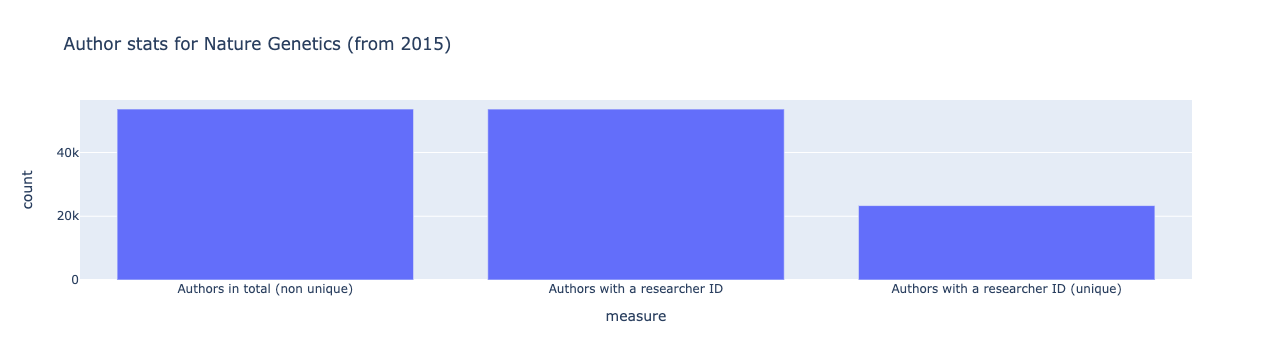

In [7]:
researchers = authors.query("researcher_id!=''")
#
df = pd.DataFrame({
    'measure' : ['Authors in total (non unique)', 'Authors with a researcher ID', 'Authors with a researcher ID (unique)'],
    'count' : [len(authors), len(researchers), researchers['researcher_id'].nunique()],
})
px.bar(df, x="measure", y="count", title=f"Author stats for {journal_title} (from {start_year})")

In [8]:
# save the researchers data to a file
save(researchers, "1_authors_with_researchers_id.csv")

## A quick look at authors *without* a Dimensions Researcher ID

We're not going to try to disambiguate them here, but still it's good to have a quick look at them... 

Looks like the most common surname is `Wang`, while the most common first name is an empty value

In [9]:
authors_without_id = authors.query("researcher_id==''")
authors_without_id[['first_name', 'last_name']].describe()

,first_name,last_name
count,13,13
unique,6,9
top,,Consortium
freq,8,4


Top ten 'ambiguous' surnames seem to be all Asian.. it's a rather known problem! 

In [10]:
authors_without_id['last_name'].value_counts()[:10]

Consortium                                  4
EPIC-CVD Consortium                         2
ReproGen Consortium                         1
Understanding Society Scientific Group      1
AFGen Consortium                            1
BioBank Japan Cooperative Hospital Group    1
EPIC-InterAct Consortium                    1
HIPSCI Consortium                           1
consortium                                  1
Name: last_name, dtype: int64

### Any common patterns? 

If we try to group the data by name+surname we can see some interesting patterns 

* some entries are things which are not persons (presumably the results of bad source data in Dimensions, eg from the publisher) 
* there are some apparently meaningful name+surname combinations with a lot of hits
* not many Asian names in the top ones 



In [11]:
authors_without_id = authors_without_id.groupby(["first_name", "last_name"]).size().reset_index().rename(columns={0: "frequency"})
authors_without_id.sort_values("frequency", ascending=False, inplace=True)
authors_without_id.head(20)

,first_name,last_name,frequency
2,,EPIC-CVD Consortium,2
0,,AFGen Consortium,1
1,,BioBank Japan Cooperative Hospital Group,1
3,,EPIC-InterAct Consortium,1
4,,HIPSCI Consortium,1
5,,ReproGen Consortium,1
6,,Understanding Society Scientific Group,1
7,BIOS,Consortium,1
8,EPIC-InterAct,Consortium,1
9,ReproGen,Consortium,1


### Creating an export for manual curation

For the next tasks, we will focus on the disambiguated authors as the Researcher ID links will let us carry out useful analyses.

Still, we can **save the authors with missing IDs** results and try to do some manual disambiguation later. To this end, adding a simple google-search URL can help in making sense of these data quickly.

In [12]:
from dimcli.shortcuts import google_url

authors_without_id['search_url'] = authors_without_id.apply(lambda x: google_url(x['first_name'] + " " +x['last_name'] ), axis=1)

authors_without_id.head(20)

,first_name,last_name,frequency,search_url
2,,EPIC-CVD Consortium,2,https://www.google.com/search?q=%20EPIC-CVD%20...
0,,AFGen Consortium,1,https://www.google.com/search?q=%20AFGen%20Con...
1,,BioBank Japan Cooperative Hospital Group,1,https://www.google.com/search?q=%20BioBank%20J...
3,,EPIC-InterAct Consortium,1,https://www.google.com/search?q=%20EPIC-InterA...
4,,HIPSCI Consortium,1,https://www.google.com/search?q=%20HIPSCI%20Co...
5,,ReproGen Consortium,1,https://www.google.com/search?q=%20ReproGen%20...
6,,Understanding Society Scientific Group,1,https://www.google.com/search?q=%20Understandi...
7,BIOS,Consortium,1,https://www.google.com/search?q=BIOS%20Consortium
8,EPIC-InterAct,Consortium,1,https://www.google.com/search?q=EPIC-InterAct%...
9,ReproGen,Consortium,1,https://www.google.com/search?q=ReproGen%20Con...


In [13]:
# save the data
save(authors_without_id, "1_authors_without_researchers_id.csv")

That's it! 

Now let's go and open this in [Google Sheets](https://docs.google.com/spreadsheets/)...

In [16]:
# for colab users: download everything
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

    import gspread
    from gspread_dataframe import get_as_dataframe, set_with_dataframe
    from oauth2client.client import GoogleCredentials

    gc = gspread.authorize(GoogleCredentials.get_application_default())

    title = 'Authors_without_IDs'
    sh = gc.create(title)
    worksheet = gc.open(title).sheet1
    set_with_dataframe(worksheet, authors_without_id)
    spreadsheet_url = "https://docs.google.com/spreadsheets/d/%s" % sh.id
    print(spreadsheet_url)